In [1]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt

curr_directory = os.getcwd()

# Player Roster Information (Copied over from player_roster.ipynb)
teams = ['BOS','BRK','NYK','PHI','TOR','CHI','CLE','DET','IND','MIL','ATL','CHO','MIA','ORL','WAS',
         'DEN','MIN','OKC','POR','UTA','GSW','LAC','LAL','PHO','SAC','DAL','HOU','MEM','NOP','SAS']
        
# Dictionary of roster
# Ex. The roster of Boston Celtics players for the 2019-2020 season can be accessed using roster['BOS']['2019']
# It does not include any players/rookies for which there is no season data
roster = {}
    
for team in teams: 
    roster[team] = {}

# Initialize set for list of all players (with no repeats)
all_players = set()
    
for filename in os.listdir(os.path.join(curr_directory, 'data_sets/player_roster')):
    data = pd.read_csv(os.path.join('data_sets/player_roster', filename))
    year = filename[0:4]
    
    for team in teams:
        roster[team][year] = []
        
        players = data.loc[data['Tm'] == team]
        for ind in players.index: 
            player_name = players['Player'][ind].split('\\', 1)[0]
            if player_name not in roster[team][year]: 
                roster[team][year].append(player_name)
            
        all_players.update(roster[team][year])

num_players = len(all_players)
        
# Player dictionary that maps all players to index
player_index = dict(zip(list(all_players), range(len(all_players))))

In [2]:
game_data = pd.read_csv(os.path.join(curr_directory,'data_sets/nba.games.stats.csv'))

# Sort all values by the Date
game_data = game_data.sort_values(by=['Date'])

In [3]:
game_results = np.array(list(game_data['TeamPoints'] - game_data['OpponentPoints']))
teams = np.array(list(zip(game_data.Team, game_data.Opponent)))
dates = np.array(list(game_data['Date']))

In [4]:
unique_dates = list(set(dates))

repeat_indexes = []

for date in unique_dates: 
    same_day = np.where(dates == date)
    # suppose same_day = [0, 1, 2, 3, 4, 5]
    for i in same_day[0]: 
        # start with i = 0
        for j in same_day[0]: 
            # j = 0, 1, 2, 3, 4, 5
            if j > i: 
                if np.array_equal(np.flip(teams[j], axis=0) , teams[i]): 
                    repeat_indexes.append(j)

# Make new unique game results, teams and dates arrays
unique_game_results = game_results[repeat_indexes]
unique_teams = teams[repeat_indexes]
unique_dates = dates[repeat_indexes]

In [5]:
# Create a class for linear regression
class LinearRegression:
    def __init__(self, step_size=1e-4, max_iter=10000, eps=1e-4, theta=None, 
                  verbose=True):
        
        self.theta = theta
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps

    def sigmoid(self, z): 
        return 1.0 / (1 + np.exp(-z))
        
    def predict(self, x):
        z = np.dot(x.T, self.theta)
        return self.sigmoid(z)
    
    def gradBatchLossFunction(self, x_teams, y_teams):
        update = 0
        for i in range(x_teams.shape[0]):
            x = x_teams[i,:]
            x_new = np.reshape(x, (2*num_players + 1, 1))
            y = np.asscalar(y_teams[i])
            update += (self.predict(x_new) - y)*x_new
            
        return update
    
    def gradminiBatchLossFunction(self, x_teams, y_teams, batch_size):
        update = 0
        data = np.array(list(zip(x_teams, y_teams)))
        data_shuffle = data
        np.random.shuffle(data_shuffle)
        
        for i in range(batch_size):
            x = data[i, :]
            y = data[:, i]
            update += (y - predict(x))*x
            
        return update
    
    def fit(self, x, y, mini = False):
        iterations = 0
        abs_error = 1
        error_list = []
        batch_size = 32
        
        if self.theta is None: 
            self.theta = np.zeros((2*num_players + 1, 1))
        
        if mini == False:
            while iterations < self.max_iter and abs_error >= self.eps:
                error = self.step_size*self.gradBatchLossFunction(x, y)
                abs_error = np.linalg.norm(error, 2)
                error_list.append(abs_error)

                theta_new = self.theta - error
                self.theta = theta_new

                iterations += 1

                print('Error: {}'.format(abs_error))
        else:
            while iterations < self.max_iter and abs_error >= self.eps:
                error = self.step_size*self.gradminiBatchLossFunction(x, y, batch_size)
                abs_error = np.linalg.norm(error, 2)
                error_list.append(abs_error)

                theta_new = self.theta - error
                self.theta = theta_new

                iterations += 1
                
                print('Error: {}'.format(abs_error))
        
        print('Convergence!')
        plt.plot(error_list)
        plt.xlabel('Iterations')
        plt.ylabel('Error')
        plt.show()
        
    def process_data(self, teams, dates, results): 
        num_games = teams.shape[0]

        # Create x for all games
        # To access x for 0th game -- x[:, 0] 
        x_without_intercept = np.zeros((num_games, 2*num_players))
        
        for i in range(num_games): 
            z, t = self.x_for_game(teams[i], dates[i])
            combined = np.vstack((z, t))
            x_without_intercept[i, :] = combined[:,0]
            
        x = self.add_intercept(x_without_intercept)
        
        # Create y for all games (if team A wins, y = 1; if team B wins, y = 0)
        y = np.zeros((num_games, 1))
        for i in range(num_games): 
            if results[i] > 0: 
                y[i] = 1
            else:
                y[i] = 0
                
        return x, y
    
    def add_intercept(self, x): 
        new_x = np.zeros((x.shape[0], x.shape[1]+1))
        new_x[:, 0] = 1
        new_x[:, 1:] = x
        
        return new_x
        
    def x_for_game(self, teams, date): 
        x_1 = np.zeros((num_players, 1))
        x_2 = np.zeros((num_players, 1))

        if int(date[5:7]) < 9: 
            year = str(int(date[0:4]) - 1)
        else: 
            year = date[0:4]

        team_1_players = roster[teams[0]][year]
        for item in team_1_players: 
            x_1[player_index[item]] = 1

        team_2_players = roster[teams[1]][year]
        for item in team_2_players: 
            x_2[player_index[item]] = 1

        return x_1, x_2

In [6]:
test = LinearRegression()
x, y = test.process_data(unique_teams[0:50], unique_dates[0:50], unique_game_results[0:50])

Error: 0.002132486811213611
Error: 0.0021298198331817773
Error: 0.002127159265257294
Error: 0.002124505091986216
Error: 0.002121857297861899
Error: 0.0021192158673265017
Error: 0.0021165807847724726
Error: 0.0021139520345440275
Error: 0.002111329600938607
Error: 0.0021087134682083205
Error: 0.00210610362056138
Error: 0.0021035000421635096
Error: 0.0021009027171393522
Error: 0.002098311629573852
Error: 0.0020957267635136286
Error: 0.0020931481029683335
Error: 0.002090575631911993
Error: 0.0020880093342843377
Error: 0.0020854491939921145
Error: 0.0020828951949103903
Error: 0.002080347320883835
Error: 0.0020778055557279934
Error: 0.002075269883230542
Error: 0.002072740287152536
Error: 0.002070216751229634
Error: 0.0020676992591733157
Error: 0.002065187794672083
Error: 0.002062682341392646
Error: 0.0020601828829811012
Error: 0.0020576894030640853
Error: 0.0020552018852499254
Error: 0.0020527203131297726
Error: 0.0020502446702787168
Error: 0.002047774940256896
Error: 0.0020453111066105873
E

Error: 0.0013981145880145125
Error: 0.0013969707109767865
Error: 0.0013958286310723344
Error: 0.001394688343702655
Error: 0.0013935498442870897
Error: 0.001392413128262731
Error: 0.001391278191084343
Error: 0.0013901450282242684
Error: 0.0013890136351723485
Error: 0.001387884007435835
Error: 0.0013867561405393062
Error: 0.0013856300300245832
Error: 0.0013845056714506452
Error: 0.0013833830603935465
Error: 0.001382262192446333
Error: 0.0013811430632189605
Error: 0.00138002566833821
Error: 0.0013789100034476095
Error: 0.001377796064207349
Error: 0.0013766838462942006
Error: 0.0013755733454014392
Error: 0.0013744645572387592
Error: 0.0013733574775321971
Error: 0.0013722521020240518
Error: 0.0013711484264728024
Error: 0.0013700464466530338
Error: 0.0013689461583553544
Error: 0.0013678475573863209
Error: 0.0013667506395683593
Error: 0.0013656554007396866
Error: 0.0013645618367542371
Error: 0.0013634699434815817
Error: 0.0013623797168068558
Error: 0.0013612911526306808
Error: 0.0013602042468

Error: 0.0011181059388409987
Error: 0.0011173544205712817
Error: 0.0011166038406191323
Error: 0.0011158541972613432
Error: 0.0011151054887792772
Error: 0.0011143577134588517
Error: 0.0011136108695905178
Error: 0.001112864955469247
Error: 0.0011121199693945104
Error: 0.001111375909670263
Error: 0.0011106327746049263
Error: 0.0011098905625113707
Error: 0.0011091492717068992
Error: 0.0011084089005132306
Error: 0.001107669447256481
Error: 0.0011069309102671495
Error: 0.0011061932878800999
Error: 0.0011054565784345439
Error: 0.0011047207802740262
Error: 0.0011039858917464064
Error: 0.001103251911203844
Error: 0.0011025188370027803
Error: 0.0011017866675039252
Error: 0.001101055401072237
Error: 0.001100325036076911
Error: 0.0010995955708913607
Error: 0.0010988670038932018
Error: 0.0010981393334642377
Error: 0.0010974125579904432
Error: 0.001096686675861949
Error: 0.0010959616854730268
Error: 0.0010952375852220726
Error: 0.001094514373511591
Error: 0.0010937920487481836
Error: 0.0010930706093

Error: 0.0008563252763476583
Error: 0.0008558686602960161
Error: 0.0008554125035690999
Error: 0.0008549568055111027
Error: 0.0008545015654674243
Error: 0.0008540467827846684
Error: 0.0008535924568106396
Error: 0.0008531385868943411
Error: 0.0008526851723859712
Error: 0.0008522322126369216
Error: 0.0008517797069997726
Error: 0.0008513276548282927
Error: 0.000850876055477434
Error: 0.000850424908303331
Error: 0.0008499742126632955
Error: 0.0008495239679158169
Error: 0.000849074173420557
Error: 0.0008486248285383483
Error: 0.0008481759326311913
Error: 0.0008477274850622517
Error: 0.0008472794851958573
Error: 0.000846831932397496
Error: 0.0008463848260338118
Error: 0.0008459381654726042
Error: 0.0008454919500828241
Error: 0.0008450461792345711
Error: 0.0008446008522990905
Error: 0.000844155968648773
Error: 0.000843711527657149
Error: 0.0008432675286988879
Error: 0.0008428239711497941
Error: 0.0008423808543868066
Error: 0.0008419381777879936
Error: 0.0008414959407325517
Error: 0.00084105414

Error: 0.000707307241264728
Error: 0.0007069899493235295
Error: 0.0007066729306875293
Error: 0.0007063561850188176
Error: 0.0007060397119800174
Error: 0.0007057235112342825
Error: 0.0007054075824452968
Error: 0.0007050919252772729
Error: 0.0007047765393949519
Error: 0.0007044614244636022
Error: 0.0007041465801490169
Error: 0.000703832006117516
Error: 0.0007035177020359427
Error: 0.0007032036675716627
Error: 0.0007028899023925646
Error: 0.0007025764061670578
Error: 0.0007022631785640718
Error: 0.0007019502192530551
Error: 0.0007016375279039742
Error: 0.0007013251041873137
Error: 0.0007010129477740728
Error: 0.0007007010583357671
Error: 0.0007003894355444264
Error: 0.0007000780790725927
Error: 0.0006997669885933213
Error: 0.0006994561637801788
Error: 0.0006991456043072414
Error: 0.0006988353098490952
Error: 0.0006985252800808349
Error: 0.0006982155146780617
Error: 0.0006979060133168846
Error: 0.0006975967756739174
Error: 0.0006972878014262791
Error: 0.0006969790902515907
Error: 0.0006966

Error: 0.0006037490778365985
Error: 0.0006035153976956596
Error: 0.0006032818932180875
Error: 0.000603048564211839
Error: 0.0006028154104851408
Error: 0.000602582431846488
Error: 0.0006023496281046448
Error: 0.0006021169990686442
Error: 0.000601884544547786
Error: 0.0006016522643516384
Error: 0.0006014201582900356
Error: 0.0006011882261730789
Error: 0.0006009564678111352
Error: 0.0006007248830148373
Error: 0.0006004934715950828
Error: 0.0006002622333630344
Error: 0.0006000311681301182
Error: 0.0005998002757080249
Error: 0.0005995695559087086
Error: 0.0005993390085443854
Error: 0.0005991086334275348
Error: 0.0005988784303708975
Error: 0.0005986483991874765
Error: 0.0005984185396905356
Error: 0.0005981888516935992
Error: 0.000597959335010452
Error: 0.0005977299894551387
Error: 0.0005975008148419634
Error: 0.0005972718109854885
Error: 0.0005970429777005359
Error: 0.0005968143148021848
Error: 0.0005965858221057727
Error: 0.0005963574994268934
Error: 0.0005961293465813986
Error: 0.000595901

Error: 0.0005244586107117027
Error: 0.0005242810246410521
Error: 0.000524103556160275
Error: 0.0005239262051549877
Error: 0.0005237489715109495
Error: 0.0005235718551140643
Error: 0.0005233948558503805
Error: 0.0005232179736060896
Error: 0.0005230412082675263
Error: 0.0005228645597211694
Error: 0.00052268802785364
Error: 0.0005225116125517025
Error: 0.0005223353137022636
Error: 0.0005221591311923725
Error: 0.0005219830649092206
Error: 0.0005218071147401411
Error: 0.0005216312805726091
Error: 0.0005214555622942412
Error: 0.000521279959792795
Error: 0.00052110447295617
Error: 0.0005209291016724057
Error: 0.0005207538458296822
Error: 0.000520578705316321
Error: 0.0005204036800207832
Error: 0.0005202287698316697
Error: 0.0005200539746377214
Error: 0.0005198792943278193
Error: 0.0005197047287909829
Error: 0.0005195302779163718
Error: 0.0005193559415932836
Error: 0.0005191817197111554
Error: 0.0005190076121595624
Error: 0.0005188336188282188
Error: 0.0005186597396069757
Error: 0.000518485974

Error: 0.0004631201615041655
Error: 0.0004629809911328487
Error: 0.0004628419028491807
Error: 0.00046270289658155135
Error: 0.00046256397225843244
Error: 0.00046242512980837675
Error: 0.000462286369160019
Error: 0.000462147690242075
Error: 0.00046200909298334193
Error: 0.0004618705773126982
Error: 0.00046173214315910313
Error: 0.0004615937904515969
Error: 0.0004614555191193009
Error: 0.0004613173290914166
Error: 0.0004611792202972265
Error: 0.00046104119266609367
Error: 0.0004609032461274609
Error: 0.000460765380610852
Error: 0.0004606275960458703
Error: 0.0004604898923621996
Error: 0.00046035226948960335
Error: 0.00046021472735792494
Error: 0.00046007726589708726
Error: 0.0004599398850370932
Error: 0.00045980258470802455
Error: 0.00045966536484004305
Error: 0.00045952822536338915
Error: 0.0004593911662083827
Error: 0.00045925418730542283
Error: 0.00045911728858498717
Error: 0.00045898046997763233
Error: 0.0004588437314139938
Error: 0.00045870707282478503
Error: 0.000458570494140799
Er

Error: 0.00041533515473050447
Error: 0.000415222795488421
Error: 0.0004151104960183
Error: 0.00041499825627291513
Error: 0.00041488607620508906
Error: 0.0004147739557676933
Error: 0.00041466189491364843
Error: 0.0004145498935959242
Error: 0.00041443795176753867
Error: 0.000414326069381559
Error: 0.0004142142463911012
Error: 0.00041410248274932957
Error: 0.0004139907784094572
Error: 0.00041387913332474607
Error: 0.00041376754744850563
Error: 0.000413656020734095
Error: 0.0004135445531349208
Error: 0.0004134331446044378
Error: 0.0004133217950961499
Error: 0.0004132105045636085
Error: 0.0004130992729604131
Error: 0.00041298810024021124
Error: 0.00041287698635669896
Error: 0.00041276593126361933
Error: 0.00041265493491476424
Error: 0.00041254399726397265
Error: 0.0004124331182651315
Error: 0.00041232229787217556
Error: 0.0004122115360390868
Error: 0.0004121008327198953
Error: 0.0004119901878686783
Error: 0.00041187960143956046
Error: 0.0004117690733867138
Error: 0.00041165860366435794
Erro

Error: 0.00037590501771810444
Error: 0.00037581268171831217
Error: 0.0003757203903564113
Error: 0.0003756281436002661
Error: 0.00037553594141777157
Error: 0.0003754437837768531
Error: 0.00037535167064546636
Error: 0.000375259601991598
Error: 0.00037516757778326463
Error: 0.00037507559798851347
Error: 0.00037498366257542195
Error: 0.0003748917715120981
Error: 0.00037479992476667967
Error: 0.00037470812230733523
Error: 0.00037461636410226345
Error: 0.00037452465011969283
Error: 0.00037443298032788225
Error: 0.0003743413546951208
Error: 0.00037424977318972747
Error: 0.0003741582357800513
Error: 0.00037406674243447126
Error: 0.00037397529312139643
Error: 0.00037388388780926587
Error: 0.00037379252646654805
Error: 0.00037370120906174225
Error: 0.00037360993556337645
Error: 0.0003735187059400092
Error: 0.00037342752016022854
Error: 0.0003733363781926521
Error: 0.00037324528000592765
Error: 0.00037315422556873193
Error: 0.0003730632148497717
Error: 0.0003729722478177833
Error: 0.0003728813244

Error: 0.0003431456066627571
Error: 0.00034306844260498183
Error: 0.00034299131270582
Error: 0.00034291421694271763
Error: 0.00034283715529314035
Error: 0.0003427601277345736
Error: 0.0003426831342445225
Error: 0.0003426061748005118
Error: 0.00034252924938008597
Error: 0.0003424523579608089
Error: 0.00034237550052026457
Error: 0.0003422986770360559
Error: 0.00034222188748580574
Error: 0.0003421451318471565
Error: 0.0003420684100977699
Error: 0.00034199172221532735
Error: 0.00034191506817752974
Error: 0.00034183844796209723
Error: 0.00034176186154676947
Error: 0.0003416853089093057
Error: 0.0003416087900274845
Error: 0.0003415323048791035
Error: 0.00034145585344198007
Error: 0.0003413794356939507
Error: 0.00034130305161287136
Error: 0.00034122670117661707
Error: 0.00034115038436308224
Error: 0.00034107410115018075
Error: 0.0003409978515158452
Error: 0.0003409216354380278
Error: 0.00034084545289469987
Error: 0.00034076930386385177
Error: 0.000340693188323493
Error: 0.00034061710625165237

Error: 0.0003180094565276922
Error: 0.0003179430255518562
Error: 0.00031787662189282275
Error: 0.00031781024553382387
Error: 0.0003177438964581052
Error: 0.00031767757464892565
Error: 0.0003176112800895582
Error: 0.0003175450127632893
Error: 0.00031747877265341905
Error: 0.00031741255974326085
Error: 0.0003173463740161422
Error: 0.00031728021545540376
Error: 0.00031721408404439993
Error: 0.0003171479797664984
Error: 0.00031708190260508067
Error: 0.00031701585254354187
Error: 0.00031694982956529007
Error: 0.0003168838336537474
Error: 0.0003168178647923491
Error: 0.0003167519229645439
Error: 0.00031668600815379426
Error: 0.00031662012034357564
Error: 0.00031655425951737746
Error: 0.0003164884256587018
Error: 0.00031642261875106483
Error: 0.00031635683877799563
Error: 0.0003162910857230372
Error: 0.0003162253595697449
Error: 0.0003161596603016885
Error: 0.00031609398790245064
Error: 0.000316028342355627
Error: 0.0003159627236448268
Error: 0.00031589713175367274
Error: 0.000315831566665800

Error: 0.00029741857191683966
Error: 0.00029736034254529886
Error: 0.00029730213561114416
Error: 0.0002972439511014641
Error: 0.00029718578900335695
Error: 0.0002971276493039307
Error: 0.0002970695319903035
Error: 0.0002970114370496032
Error: 0.0002969533644689672
Error: 0.0002968953142355432
Error: 0.0002968372863364886
Error: 0.0002967792807589702
Error: 0.00029672129749016527
Error: 0.00029666333651726025
Error: 0.0002966053978274517
Error: 0.0002965474814079459
Error: 0.0002964895872459589
Error: 0.00029643171532871645
Error: 0.0002963738656434539
Error: 0.0002963160381774165
Error: 0.0002962582329178595
Error: 0.00029620044985204726
Error: 0.0002961426889672544
Error: 0.0002960849502507649
Error: 0.00029602723368987255
Error: 0.00029596953927188077
Error: 0.00029591186698410256
Error: 0.0002958542168138609
Error: 0.00029579658874848814
Error: 0.00029573898277532627
Error: 0.00029568139888172713
Error: 0.000295623837055052
Error: 0.00029556629728267177
Error: 0.00029550877955196697

Error: 0.0002758404883983219
Error: 0.0002757902811282797
Error: 0.00027574009183919815
Error: 0.00027568992052145856
Error: 0.0002756397671654489
Error: 0.0002755896317615639
Error: 0.0002755395143002051
Error: 0.000275489414771781
Error: 0.00027543933316670683
Error: 0.0002753892694754048
Error: 0.0002753392236883036
Error: 0.0002752891957958389
Error: 0.0002752391857884534
Error: 0.0002751891936565963
Error: 0.0002751392193907234
Error: 0.00027508926298129777
Error: 0.0002750393244187889
Error: 0.00027498940369367333
Error: 0.000274939500796434
Error: 0.0002748896157175609
Error: 0.0002748397484475506
Error: 0.00027478989897690637
Error: 0.00027474006729613854
Error: 0.0002746902533957638
Error: 0.00027464045726630575
Error: 0.00027459067889829485
Error: 0.0002745409182822677
Error: 0.00027449117540876826
Error: 0.0002744414502683468
Error: 0.0002743917428515605
Error: 0.00027434205314897313
Error: 0.00027429238115115516
Error: 0.0002742427268486837
Error: 0.0002741930902321426
Erro

Error: 0.00025793073709324383
Error: 0.00025788674199521736
Error: 0.00025784276165840506
Error: 0.00025779879607540883
Error: 0.0002577548452388361
Error: 0.0002577109091412988
Error: 0.0002576669877754138
Error: 0.0002576230811338031
Error: 0.0002575791892090936
Error: 0.00025753531199391696
Error: 0.00025749144948090973
Error: 0.0002574476016627136
Error: 0.00025740376853197495
Error: 0.0002573599500813453
Error: 0.0002573161463034805
Error: 0.0002572723571910421
Error: 0.00025722858273669595
Error: 0.0002571848229331128
Error: 0.00025714107777296863
Error: 0.00025709734724894403
Error: 0.0002570536313537245
Error: 0.0002570099300800004
Error: 0.000256966243420467
Error: 0.0002569225713678244
Error: 0.00025687891391477767
Error: 0.0002568352710540363
Error: 0.0002567916427783152
Error: 0.0002567480290803339
Error: 0.0002567044299528166
Error: 0.00025666084538849247
Error: 0.00025661727538009535
Error: 0.00025657371992036433
Error: 0.00025653017900204283
Error: 0.00025648665261787944

Error: 0.00024163053388365102
Error: 0.00024159184030043607
Error: 0.00024155315890216693
Error: 0.00024151448968311287
Error: 0.0002414758326375468
Error: 0.000241437187759745
Error: 0.00024139855504398753
Error: 0.000241359934484558
Error: 0.00024132132607574346
Error: 0.00024128272981183474
Error: 0.0002412441456871261
Error: 0.00024120557369591527
Error: 0.00024116701383250386
Error: 0.0002411284660911968
Error: 0.00024108993046630274
Error: 0.00024105140695213358
Error: 0.00024101289554300513
Error: 0.00024097439623323662
Error: 0.00024093590901715081
Error: 0.00024089743388907393
Error: 0.00024085897084333594
Error: 0.00024082051987427009
Error: 0.00024078208097621357
Error: 0.0002407436541435066
Error: 0.00024070523937049342
Error: 0.00024066683665152137
Error: 0.00024062844598094155
Error: 0.00024059006735310858
Error: 0.0002405517007623807
Error: 0.00024051334620311935
Error: 0.00024047500366968964
Error: 0.00024043667315646044
Error: 0.00024039835465780384
Error: 0.0002403600

Error: 0.00022751440709854861
Error: 0.0002274800330415222
Error: 0.00022744566919500692
Error: 0.00022741131555447378
Error: 0.0002273769721153968
Error: 0.0002273426388732525
Error: 0.00022730831582352032
Error: 0.00022727400296168205
Error: 0.00022723970028322234
Error: 0.00022720540778362852
Error: 0.0002271711254583905
Error: 0.0002271368533030009
Error: 0.00022710259131295492
Error: 0.00022706833948375057
Error: 0.00022703409781088833
Error: 0.0002269998662898715
Error: 0.00022696564491620592
Error: 0.00022693143368540013
Error: 0.00022689723259296528
Error: 0.00022686304163441526
Error: 0.0002268288608052664
Error: 0.00022679469010103792
Error: 0.0002267605295172514
Error: 0.00022672637904943156
Error: 0.00022669223869310507
Error: 0.00022665810844380168
Error: 0.00022662398829705377
Error: 0.00022658987824839615
Error: 0.0002265557782933664
Error: 0.00022652168842750463
Error: 0.0002264876086463538
Error: 0.00022645353894545908
Error: 0.0002264194793203687
Error: 0.000226385429

Error: 0.00021484101562008534
Error: 0.0002148103046231849
Error: 0.00021477960225566142
Error: 0.0002147489085138953
Error: 0.00021471822339426874
Error: 0.00021468754689316625
Error: 0.00021465687900697417
Error: 0.00021462621973208093
Error: 0.00021459556906487694
Error: 0.0002145649270017546
Error: 0.0002145342935391085
Error: 0.00021450366867333497
Error: 0.00021447305240083255
Error: 0.00021444244471800167
Error: 0.00021441184562124497
Error: 0.00021438125510696686
Error: 0.0002143506731715738
Error: 0.0002143200998114744
Error: 0.00021428953502307908
Error: 0.00021425897880280042
Error: 0.00021422843114705288
Error: 0.00021419789205225304
Error: 0.00021416736151481946
Error: 0.0002141368395311724
Error: 0.00021410632609773458
Error: 0.00021407582121093046
Error: 0.0002140453248671865
Error: 0.00021401483706293118
Error: 0.0002139843577945948
Error: 0.00021395388705861007
Error: 0.00021392342485141135
Error: 0.00021389297116943491
Error: 0.0002138625260091193
Error: 0.00021383208

Error: 0.00020532273651960545
Error: 0.00020529464279043483
Error: 0.00020526655661624543
Error: 0.0002052384779940053
Error: 0.0002052104069206836
Error: 0.00020518234339325146
Error: 0.00020515428740868133
Error: 0.00020512623896394767
Error: 0.0002050981980560261
Error: 0.00020507016468189433
Error: 0.00020504213883853115
Error: 0.0002050141205229176
Error: 0.00020498610973203581
Error: 0.00020495810646286967
Error: 0.00020493011071240474
Error: 0.00020490212247762816
Error: 0.0002048741417555287
Error: 0.00020484616854309678
Error: 0.00020481820283732414
Error: 0.00020479024463520456
Error: 0.0002047622939337331
Error: 0.00020473435072990658
Error: 0.0002047064150207233
Error: 0.00020467848680318342
Error: 0.00020465056607428823
Error: 0.00020462265283104105
Error: 0.00020459474707044666
Error: 0.00020456684878951135
Error: 0.00020453895798524317
Error: 0.00020451107465465154
Error: 0.0002044831987947478
Error: 0.00020445533040254441
Error: 0.00020442746947505597
Error: 0.000204399

Error: 0.00019755851015510254
Error: 0.0001975324662917558
Error: 0.00019750642917566036
Error: 0.00019748039880420801
Error: 0.000197454375174792
Error: 0.0001974283582848063
Error: 0.00019740234813164678
Error: 0.00019737634471271045
Error: 0.0001973503480253955
Error: 0.00019732435806710187
Error: 0.00019729837483523045
Error: 0.0001972723983271836
Error: 0.00019724642854036505
Error: 0.00019722046547217977
Error: 0.0001971945091200343
Error: 0.00019716855948133613
Error: 0.00019714261655349452
Error: 0.0001971166803339196
Error: 0.00019709075082002323
Error: 0.00019706482800921842
Error: 0.00019703891189891951
Error: 0.00019701300248654223
Error: 0.00019698709976950345
Error: 0.00019696120374522165
Error: 0.00019693531441111642
Error: 0.0001969094317646088
Error: 0.00019688355580312108
Error: 0.00019685768652407694
Error: 0.0001968318239249013
Error: 0.0001968059680030204
Error: 0.00019678011875586186
Error: 0.00019675427618085463
Error: 0.00019672844027542893
Error: 0.000196702611

Error: 0.0001881724707098675
Error: 0.00018814880276219308
Error: 0.00018812514066429616
Error: 0.00018810148441402016
Error: 0.0001880778340092091
Error: 0.00018805418944770828
Error: 0.00018803055072736408
Error: 0.00018800691784602377
Error: 0.00018798329080153578
Error: 0.0001879596695917498
Error: 0.0001879360542145161
Error: 0.00018791244466768645
Error: 0.00018788884094911345
Error: 0.00018786524305665074
Error: 0.00018784165098815328
Error: 0.00018781806474147674
Error: 0.00018779448431447798
Error: 0.00018777090970501488
Error: 0.00018774734091094638
Error: 0.00018772377793013266
Error: 0.0001877002207604346
Error: 0.0001876766693997144
Error: 0.00018765312384583528
Error: 0.00018762958409666126
Error: 0.0001876060501500577
Error: 0.0001875825220038909
Error: 0.00018755899965602795
Error: 0.00018753548310433766
Error: 0.00018751197234668916
Error: 0.000187488467380953
Error: 0.0001874649682050007
Error: 0.00018744147481670478
Error: 0.00018741798721393885
Error: 0.000187394505

Error: 0.00018082038175973642
Error: 0.0001807984967430229
Error: 0.0001807766169310744
Error: 0.00018075474232204475
Error: 0.00018073287291408882
Error: 0.00018071100870536213
Error: 0.00018068914969402117
Error: 0.0001806672958782233
Error: 0.00018064544725612675
Error: 0.00018062360382589047
Error: 0.00018060176558567462
Error: 0.00018057993253364
Error: 0.0001805581046679482
Error: 0.00018053628198676182
Error: 0.0001805144644882444
Error: 0.00018049265217056002
Error: 0.00018047084503187402
Error: 0.0001804490430703524
Error: 0.00018042724628416205
Error: 0.00018040545467147058
Error: 0.00018038366823044675
Error: 0.00018036188695926
Error: 0.0001803401108560807
Error: 0.00018031833991908006
Error: 0.00018029657414643006
Error: 0.00018027481353630374
Error: 0.00018025305808687487
Error: 0.00018023130779631802
Error: 0.0001802095626628088
Error: 0.00018018782268452353
Error: 0.00018016608785963937
Error: 0.00018014435818633457
Error: 0.00018012263366278786
Error: 0.000180100914287

Error: 0.0001722439358917929
Error: 0.00017222404393182927
Error: 0.00017220415648581342
Error: 0.0001721842735522182
Error: 0.00017216439512951698
Error: 0.00017214452121618387
Error: 0.00017212465181069337
Error: 0.0001721047869115212
Error: 0.00017208492651714336
Error: 0.0001720650706260367
Error: 0.00017204521923667863
Error: 0.00017202537234754737
Error: 0.00017200552995712192
Error: 0.00017198569206388156
Error: 0.00017196585866630676
Error: 0.0001719460297628783
Error: 0.00017192620535207782
Error: 0.00017190638543238763
Error: 0.00017188657000229068
Error: 0.00017186675906027051
Error: 0.00017184695260481165
Error: 0.00017182715063439896
Error: 0.00017180735314751815
Error: 0.00017178756014265558
Error: 0.00017176777161829844
Error: 0.00017174798757293424
Error: 0.00017172820800505153
Error: 0.00017170843291313944
Error: 0.00017168866229568756
Error: 0.0001716688961511865
Error: 0.00017164913447812732
Error: 0.00017162937727500184
Error: 0.0001716096245403026
Error: 0.00017158

Error: 0.0001648141189282734
Error: 0.0001647958779529763
Error: 0.00016477764094459036
Error: 0.00016475940790182947
Error: 0.00016474117882340835
Error: 0.00016472295370804194
Error: 0.0001647047325544459
Error: 0.00016468651536133644
Error: 0.0001646683021274303
Error: 0.00016465009285144487
Error: 0.0001646318875320979
Error: 0.0001646136861681078
Error: 0.00016459548875819366
Error: 0.00016457729530107483
Error: 0.00016455910579547142
Error: 0.0001645409202401041
Error: 0.000164522738633694
Error: 0.00016450456097496288
Error: 0.000164486387262633
Error: 0.00016446821749542702
Error: 0.00016445005167206852
Error: 0.00016443188979128136
Error: 0.00016441373185179
Error: 0.00016439557785231942
Error: 0.0001643774277915953
Error: 0.0001643592816683436
Error: 0.00016434113948129108
Error: 0.0001643230012291649
Error: 0.00016430486691069288
Error: 0.0001642867365246033
Error: 0.00016426861006962507
Error: 0.00016425048754448748
Error: 0.00016423236894792052
Error: 0.0001642142542786547

Error: 0.0001579721513479778
Error: 0.00015795536859468688
Error: 0.0001579385893449963
Error: 0.000157921813597816
Error: 0.00015790504135205623
Error: 0.00015788827260662783
Error: 0.00015787150736044212
Error: 0.00015785474561241076
Error: 0.0001578379873614459
Error: 0.00015782123260646013
Error: 0.0001578044813463666
Error: 0.00015778773358007865
Error: 0.00015777098930651047
Error: 0.00015775424852457632
Error: 0.00015773751123319109
Error: 0.00015772077743127002
Error: 0.00015770404711772896
Error: 0.0001576873202914841
Error: 0.00015767059695145203
Error: 0.00015765387709654988
Error: 0.00015763716072569517
Error: 0.00015762044783780604
Error: 0.0001576037384318007
Error: 0.0001575870325065982
Error: 0.00015757033006111776
Error: 0.00015755363109427935
Error: 0.00015753693560500295
Error: 0.00015752024359220947
Error: 0.0001575035550548198
Error: 0.00015748686999175567
Error: 0.00015747018840193896
Error: 0.0001574535102842923
Error: 0.00015743683563773845
Error: 0.000157420164

Error: 0.00015230471488298175
Error: 0.00015228909487214893
Error: 0.00015227347800937828
Error: 0.00015225786429372444
Error: 0.00015224225372424227
Error: 0.00015222664629998729
Error: 0.000152211042020015
Error: 0.00015219544088338152
Error: 0.00015217984288914342
Error: 0.00015216424803635758
Error: 0.00015214865632408092
Error: 0.00015213306775137134
Error: 0.0001521174823172866
Error: 0.00015210190002088518
Error: 0.00015208632086122575
Error: 0.00015207074483736737
Error: 0.00015205517194836953
Error: 0.00015203960219329214
Error: 0.00015202403557119538
Error: 0.00015200847208113975
Error: 0.00015199291172218632
Error: 0.00015197735449339644
Error: 0.00015196180039383182
Error: 0.0001519462494225545
Error: 0.00015193070157862703
Error: 0.00015191515686111212
Error: 0.00015189961526907315
Error: 0.0001518840768015736
Error: 0.00015186854145767746
Error: 0.00015185300923644906
Error: 0.00015183748013695313
Error: 0.0001518219541582547
Error: 0.0001518064312994192
Error: 0.00015179

Error: 0.00014695066689724716
Error: 0.0001469361077178887
Error: 0.00014692155137337824
Error: 0.00014690699786289348
Error: 0.00014689244718561246
Error: 0.00014687789934071327
Error: 0.00014686335432737466
Error: 0.00014684881214477538
Error: 0.00014683427279209453
Error: 0.0001468197362685119
Error: 0.00014680520257320706
Error: 0.00014679067170536038
Error: 0.00014677614366415215
Error: 0.0001467616184487633
Error: 0.00014674709605837474
Error: 0.00014673257649216805
Error: 0.00014671805974932495
Error: 0.00014670354582902738
Error: 0.00014668903473045777
Error: 0.00014667452645279877
Error: 0.00014666002099523342
Error: 0.00014664551835694495
Error: 0.00014663101853711706
Error: 0.0001466165215349336
Error: 0.0001466020273495789
Error: 0.0001465875359802374
Error: 0.00014657304742609408
Error: 0.00014655856168633414
Error: 0.000146544078760143
Error: 0.00014652959864670657
Error: 0.0001465151213452109
Error: 0.00014650064685484246
Error: 0.0001464861751747881
Error: 0.00014647170

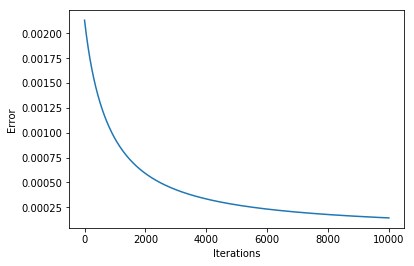

In [7]:
# Fit training set
test.fit(x, y, False)

In [8]:
# Load 2015 playoff data
playoff_data = pd.read_csv(os.path.join(curr_directory,'data_sets/2015_playoffs.csv'))

raw_playoff_results = np.array(list(playoff_data['PTS'] - playoff_data['PTS.1']))
raw_playoff_team_pairs = np.array(list(zip(playoff_data['Visitor/Neutral'], playoff_data['Home/Neutral'])))
raw_playoff_dates = np.array(list(playoff_data['Date']))

In [9]:
playoff_pairs = {}

for i in range(len(raw_playoff_team_pairs)): 
    team_1 = raw_playoff_team_pairs[i][0]
    team_2 = raw_playoff_team_pairs[i][1]
    if (team_1,team_2) in playoff_pairs.keys(): 
        # if results > 0 --> team A won --> +1
        # if results < 0 --> team B won --> -1
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_1,team_2] += 1
        else: 
            playoff_pairs[team_1,team_2] += -1
    elif (team_2,team_1) in playoff_pairs.keys():
        # if results > 0 --> team B won --> -1
        # if results < 0 --> team A won --> +1
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_2,team_1] += -1
        else: 
            playoff_pairs[team_2,team_1] += 1
    else: 
        if raw_playoff_results[i] > 0: 
            playoff_pairs[team_1,team_2] = 1
        else: 
            playoff_pairs[team_1,team_2] = -1
            
print(playoff_pairs)

{('WAS', 'TOR'): 4, ('NOP', 'GSW'): -4, ('MIL', 'CHI'): -2, ('DAL', 'HOU'): -3, ('BOS', 'CLE'): -4, ('BRK', 'ATL'): -2, ('POR', 'MEM'): -3, ('SAS', 'LAC'): -1, ('WAS', 'ATL'): -2, ('MEM', 'GSW'): -2, ('CHI', 'CLE'): -2, ('LAC', 'HOU'): -1, ('HOU', 'GSW'): -3, ('CLE', 'ATL'): 4, ('CLE', 'GSW'): -2}


In [10]:
playoff_teams = []
playoff_results = []
playoff_dates = []

for key in playoff_pairs: 
    playoff_teams.append([key[0], key[1]])
    playoff_results.append(playoff_pairs[key])
    playoff_dates.append('2015-04-10')
    
playoff_teams = np.array(playoff_teams)
playoff_results = np.array(playoff_results)
playoff_dates = np.array(playoff_dates)

playoff_x, playoff_y = test.process_data(playoff_teams, playoff_dates, playoff_results)

print(playoff_x)
print(playoff_y)

predicted_y = []
temp = playoff_x[0,:]
for i in range(playoff_x.shape[0]):
    x = playoff_x[i,:]
    print(np.mean(temp == x))
    
    x_new = np.reshape(x, (2*num_players + 1, 1))
    prediction = test.predict(x_new)
    if np.asscalar(prediction) > 0.5: 
        predicted_y.append(1)
    else: 
        predicted_y.append(0)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]
1.0
0.964193046185781
0.9652309289050337
0.9626362221069019
0.9610793980280228
0.9647119875454073
0.9636741048261547
0.9636741048261547
0.9839128178515828
0.9652309289050337
0.9652309289050337
0.9621172807472755
0.9647119875454073
0.964193046185781
0.9647119875454073


In [11]:
prediction_accuracy = np.mean(np.array(predicted_y) == np.array(playoff_y.T[0][:]))
print(prediction_accuracy)
print(predicted_y)
print(np.array(predicted_y) == np.array(playoff_y.T[0][:]))

0.6666666666666666
[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
[False  True False  True  True  True  True False  True  True False  True
  True False  True]


In [12]:
test_x, test_y = test.process_data(unique_teams[2230:3000], unique_dates[2230:3000], unique_game_results[2230:3000])

In [13]:
predicted_y = []
for i in range(test_x.shape[0]):
    x = test_x[i,:]
    
    x_new = np.reshape(x, (2*num_players + 1, 1))
    prediction = test.predict(x_new)
    if np.asscalar(prediction) > 0.5: 
        predicted_y.append(1)
    else: 
        predicted_y.append(0)
        
predicted_y = np.array(predicted_y)

In [14]:
print(np.mean(np.array(predicted_y) == np.array(test_y.T)))

0.522077922077922
